### Calculate wind stress energy into the domain and kinetic energy

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [3]:
nx = 512
ny = 612
nz = 76
nt = 720
dt = 600 # sec
z1 = 25 # Zl[25] = -99 m
z2 = 37 # Zl[37] = -197.2 m
z3 = 45 # Zl[45] = -292.2 m
z4 = 55 # Zl[55] = -508.2 m

depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_nob,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# centers mask bathy with bay
depth_bay = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

### Energy from wind

Eg. intro in https://www.sciencedirect.com/science/article/pii/S0967063708001994 or
https://journals.ametsoc.org/view/journals/phoc/36/2/jpo2842.1.xml

Wind power input per unit area

$$P =\vec{u_s}\cdot\vec{\tau},$$
where $\vec{u_s}$ is the surface velocity and $\vec{\tau}$ is the wind stress (these should probably be 3D quantities $(u,v,w)$ and ($\tau_x$,$\tau_y$,Pressure?), but lest's just use the horizontal components).

Then, an integral of P over area gives a flux of energy in J/s.

Do I have surface velocities?

In [4]:
#print(f'{ds.Z.data[0]}')
print('%1.3f' %ds.Z.data[0])

-3.000


Nope, I have vel at 3 m depth. Come back to fix this.

In [5]:
## Make wind stress array

## Gaussian pulse
t = np.linspace(0,nt*0.167,nt) # time array of wind records
max_tau = 0.1 # W/m^2
sigma = 1
center = 3.5 # base 3.5 hr, faster 2.5 hr, slower 4.5
gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))
mask = t>center
gauss[mask]=0

## Rotation angle (in deg) to get alongshore winds (see previous notebook)
angle_up = 300. # upwelling favourable

## Grid size
lat_bot = 27.0 
lat_top = 35.3 

## Region where winds will blow (over SVB: 27.9, 30.0, -115.1, -114)
lat1 = 27.0 
lat2 = 35.3 
lon1 = -122 # -122 domain 5
lon2 = -114

## Domain boundaries
lon_ini = -122.0 # -122.0 domain 5
lon_end = -114.0
lat_ini = 27.0
lat_end = 35.3    
    
### Rotate winds
windstress= np.expand_dims(np.expand_dims(gauss,1),1) + np.zeros((nt,ny,nx))
alpha = np.radians(angle_up)

zonal_tau = windstress*np.cos(alpha)
merid_tau = windstress*np.sin(alpha)

(0.0, 20.0)

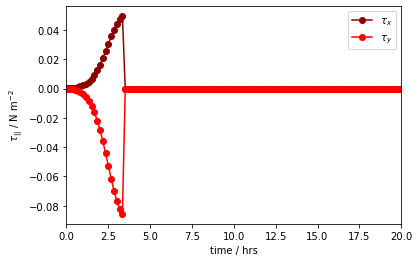

In [6]:
plt.plot(t,zonal_tau[:,0,0],'-o', color='darkred', label=r'$\tau_x$')
plt.plot(t,merid_tau[:,0,0],'-o', color='red', label=r'$\tau_y$')
plt.legend()
plt.xlabel('time / hrs')
plt.ylabel(r'$\tau_{||}$ / N m$^{-2}$')
plt.xlim(0,20)

In [7]:
# Calculate P = \vec{u}\cdot\vec{\tau}

# unstagger first, come back to do this properly!
P = ds.UVEL.data[:nt,0,...]*zonal_tau + ds.VVEL.data[:nt,0,...]*merid_tau

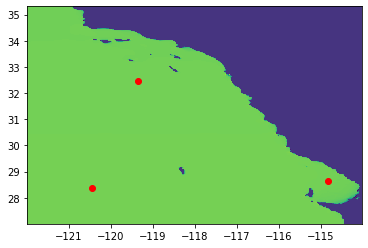

In [8]:
plt.pcolormesh(lon,lat,P[20,:,:])
p1 = [100,100]
p2 = [460,120]
p3 = [170,400]

plt.plot(lon[p1[0]],lat[p1[1]],'ro')
plt.plot(lon[p2[0]],lat[p2[1]],'ro')
plt.plot(lon[p3[0]],lat[p3[1]],'ro')

In [13]:
tend=144

In [14]:
# Calclulate energy flux in J/s over whole domain (surface integrated)
# rA area tracer cells
dA = np.expand_dims(ds.rA.data,0) + np.zeros((nt,ny,nx))
Ewind = np.nansum(np.nansum(dA*P, axis=1),axis=1)

In [ ]:
fig,ax = plt.subplots(1,1)
for tt,ee in zip(t,Ewind):
    ax.plot(tt,ee,'ro')
    
